# Heat Equation Solvers

##### Plan of Attack
1. Create Explicit solver algorithm and ensure accurate solutions [DONE]
2. Create variable for function with sympy compatibility (!Uneccessary!) [DONE - ELSEWHERE]
3. Create an implicit solver algorithm  [DONE]
4. Create Crank-Nicolson algorithm [DONE]
5. Add in fourier analysis [ISSUES]
6. Explore library methods [DONE]
7. Add in updating graph to show heat equation working ("video") [DONE]
8. 2D heat equation [TODO]
9. Clean up and refactor (use numpy matric manip for explicit), create standalong .py algorithms file [DONE]

##### Next Steps (for future notebooks)
1. 3D Heat Equation?
2. Expand to other (linear) wave/wavelike phenomenon
3. Expore nonlinear waves

-----

## 1-D Heat Equation (2nd Order PDE):
# $u_{t}$ = $\gamma$$u_{xx}$ =
# $\frac{\partial{u}}{\partial{t}}$ = $\gamma$$\frac{\partial^2{u}}{\partial{x}^2}$
#### where $\gamma$ = diffusion coefficient (also given as 'D')

## Section I: Create base equation and check

### Step 0: Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

import sympy as sp # Not needed but imported for potential future use

### Step 1: Define Variables

In [ ]:
# Givens:
D = 5 # diffusion coefficient (gamma above)
dx = .1 # Discrete x step
L = 3 # Length of 'rod'

# Derived:
dt = dx**2 / (2*D) # dt = .001, should be equal to or less than dx^2/(2*D) for non blowup requirements
mu = D * (dt/dx**2) # Necessary Coefficient
Nx = int(L/dx)

#Can also use your own dx:
# N = *choose an integer*
# dx = L/N

print('N = ',Nx)

### Step 2: Codify Initial Conditions

In [ ]:
# f(x) = u(t=0,x)
def f(x):
    return x * (x - 1) * (x - 3)

# Initialize Array
U = []

# Create holder for first row of array = the initial conditions
u_t_x_0 = []

# Populate holder with Initial Conditions, need N+ to include both x = 0 and x = L = 3
for i in range(Nx+1):
    n = i * dx
    u_t_x_0.append(f(n))
U.append(u_t_x_0)
U

### Step 3: Iterate Using Heat Equation (diffusion equation)

In [ ]:
t = 1000 # Time steps to examine

# Run this loop the number of time steps you want to analyze ('_' is a placeholder for loop count)
for _ in range(t):

    # First, create empty time step - basically initize a list of u(t,x) to fill
    u_t_x = []
    # Now grab the last time step line (the value of u at each x for the previous t)
    u_line = U[-1]
    
    for i in range(1,Nx):
        # Equation 5.14 (slightly modified) to calculate u at each x value:
        u = u_line[i] + mu*(u_line[i+1] + u_line[i-1] - 2*u_line[i])
        # Append this value to the time step line
        u_t_x.append(u)

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,0)
    u_t_x.insert(len(u_line),0)

    # Now append the full solutions matrix
    U.append(u_t_x) 

In [ ]:
# Display Solutions as a dataframe (for personal convenience)
df = pd.DataFrame(U).round(3)
df

In [ ]:
# Plotting t = 0 to t = 1000, in 20dt increments
for i in np.arange(0,len(U),20):
    plt.plot(U[i])
    plt.xlabel('x')
    plt.ylabel('T')
    plt.text(0,-1.75,"Lines represent time values")
plt.show()

In [ ]:
def heat_plotter(U, steps):

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('x')  # Set x-axis label
    ax.set_ylabel('T')  # Set y-axis label

    # Set the y-axis limits
    y_min = min([min(u) for u in U]) - 0.5  # Find the minimum y-value in U with some buffer
    y_max = max([max(u) for u in U]) + 0.5  # Find the maximum y-value in U with some buffer
    ax.set_ylim(y_min, y_max)

    lines = []  # List to store line objects
    alpha_decay = .5  # Factor to reduce the alpha of previous lines

    plt.show()

    for i in np.arange(0, len(U), len(U)//steps):
        # Update the alpha values of existing lines
        for line in lines:
            line.set_alpha(line.get_alpha() * alpha_decay)

        # Add new line
        new_line, = ax.plot(U[i], color='red', alpha=1.0)  # Start with full opacity
        lines.append(new_line)  # Store the new line object
        ax.set_title(f"Plot at time = {i/(len(U)-1)}s")  # Update the title with the current step

        # Handling plot display
        clear_output(wait=True)  # Clear the previous plot
        display(fig)  # Display the current figure

        time.sleep(0.25)  # Pause for half a second before the next update

In [ ]:
heat_plotter(U,20)

### Step 4: Create function

In [ ]:
def heat_1d(f_u_0_x, D, dx, L, f_u_t_0, f_u_t_L, t_max, dt_mod=1):
    '''
    This function takes in an initial temperature distribution, along with boundary conditions,
    and emits the changes to the temperature distribution based on finite difference analysis.
    
    NOTE 1: This function is NOT optimized for numpy use in Python.  It works well for simple problems, but
    needs to be updated to use Numpy arrays for large datasets.
    
    Parameters:    
    f = the function governing the initial heat condition in the rod, must be a def f() [function]
    D = Heat diffusion constant (aka gamma) [float]
    dx = distance between analysis nodes [float]
    L = length of rod [float]
    u_t_0 = Boundary condition at zero [float]
    u_t_L = Boundary Condition at L [float]
    t_max = max time [integer or float]
    dt_mod = (optional) alter this to change then impact of the time interval in caase solutions are unstable
    
    Returns:
    U = array containing the temperature distributions across length L at time step t=0 to t=t_max
    '''
    
    # First set the time step such that dt </= dx**2/(2*D); this determines mu:
    dt = dx**2 / (2*D) # dt = .001, should be equal to or less than dx^2/(2*D) for stability requirements
    mu = D * (dt/dx**2) * dt_mod # Related to dt above, must be </= to .5
    
    # Generate x nodes across rod:
    Nx = int(L/dx)
    
    # Initialize Array:
    U = []

    # Create holder for first row of array = the initial temperature distribution:
    u_t_x_0 = []

    # Populate holder with initial distribution, need N+1 to include x = 3
    for i in range(Nx+1):
        # Normalize the step
        n = i*dx
        
        # Solve the initial value equation for each node:
        # This try/except statement is put in in case the initial condition is a constant:
        try:
            f_n = f_u_0_x(n)
        except:
            f_n = f_u_0_x
            
        u_t_x_0.append(f_n)
    
    # Replace initial distribution boundary conditions with, well, boundary conditions
    try:
        u_t_x_0[0] = f_u_t_0(0)
    except:
        u_t_x_0[0] = f_u_t_0
            
    try:
        u_t_x_0[-1] = f_u_t_L(0)
    except:
        u_t_x_0[-1] = f_u_t_L
    
    # Add this first row to the Array to return
    U.append(u_t_x_0)

    # Run this loop the number of time steps you want to analyze (note: '_' is a placeholder for loop count)
    for t in range(t_max):

        # First, create empty time step - basically initize an empty list to fill with u(t,x) :
        u_t_x = []
        
        # Now grab the previous time step distribution (the value of u at each x for the previous t):
        u_line = U[-1]

        # Now loop through all 'inner' values, that is 0 < x < L, requiring a range of 1 to N:
        for i in range(1,Nx):
            # Using a modified equation 5.14 to calculate u at each x value:
            u = u_line[i] + mu*(u_line[i+1] + u_line[i-1] - 2*u_line[i])
            # Append this value to the time step line:
            u_t_x.append(u)

        # Append the first and last values with the boundary conditions.  Use try and except in case constant
        try:
            a = f_u_t_0(t)
        except:
            a = f_u_t_0
            
        try:
            b = f_u_t_L(t)
        except:
            b = f_u_t_L
        
        u_t_x.insert(0,a)
        u_t_x.insert(len(u_line),b)

        # Now append the full solutions matrix with time step distribution:
        U.append(u_t_x) 

    return U

Example of using the function with a boundary condition that is itself a function:

In [ ]:
f = 20 # Function is constant
D = 4.25e-6
dx = .0001
L = .01
u_t_0 = 50
#u_t_L = 0  ! - Commented this out since we are replacing it with the function below

def u_t_L(t):
    return t/10

t_max = 1000

U2 = heat_1d(f, D, dx, L, u_t_0, u_t_L, t_max)

In [ ]:
df = pd.DataFrame(U2).round(2)
df

In [ ]:
plt.figure(figsize = (12,12))
for i in np.arange(0,1000,50):
    plt.plot(U2[i], label = f't = {round(i*dt,2)}s')
plt.legend()
plt.xlabel('x')
plt.ylabel('T')
plt.text(20,80,'Left boundary = 50 (constant); Right boundary = t/100')
plt.text(20,76,'Initial conditions = 20 (constant)')
plt.show()

In [ ]:
def heat_plotter_advanced(U, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot):
    
    dt = t_max/len(U)
    t_min_index = int(t_min_plot / dt)
    t_max_index = int(t_max_plot / dt)
    print('t_min_index:',t_min_index)
    print('t_max_index:',t_max_index)
    
    dx = L/len(U[0])
    x_min_index = int(x_min_plot / dx)
    x_max_index = int(x_max_plot / dx)
    print('x_min_index:',x_min_index)
    print('x_max_index:',x_max_index)

    # Create slice to analyze
    U_slice = U[t_min_index:t_max_index]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('x')  # Set x-axis label
    ax.set_ylabel('T')  # Set y-axis label

    # Set the y-axis limits
    y_min = min([min(u) for u in U_slice]) - 0.5  # Find the minimum y-value in U with some buffer
    y_max = max([max(u) for u in U_slice]) + 0.5  # Find the maximum y-value in U with some buffer
    ax.set_ylim(y_min, y_max)

    # Set the x-axis limits
    ax.set_xlim(x_min_plot, x_max_plot)
    
    lines = []  # List to store line objects
    alpha_decay = .5  # Factor to reduce the alpha of previous lines

    plt.show()

    for i in np.arange(0, len(U_slice), len(U_slice)//steps):
        # Update the alpha values of existing lines
        for line in lines:
            line.set_alpha(line.get_alpha() * alpha_decay)

        # Compute scaled x-axis values
        x_values = np.linspace(0, L, len(U_slice[i]))
        x_values_used = x_values[x_min_index:x_max_index+1]
        
        # Add new line
        new_line, = ax.plot(x_values_used,U_slice[i][x_min_index:x_max_index+1], color='red', alpha=1.0)  # Start with full opacity
        lines.append(new_line)  # Store the new line object
        ax.set_title(f"Plot at time = {i/(len(U_slice)-1)}s")  # Update the title with the current step

        # Handling plot display
        clear_output(wait=True)  # Clear the previous plot
        display(fig)  # Display the current figure

        time.sleep(0.25)  # Pause for half a second before the next update   

In [ ]:
#heat_plotter_advanced(U, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot)
heat_plotter_advanced(U2, L, 1, 20, .2, .9, .005, .01)

#### Additional Example - Has different initial condition regimes:

In [ ]:
def f3(x):
    if x < (np.pi/2):
        return x
    else:
        return np.pi-x
    
D = 1
dx = np.pi/24
L = np.pi
u_t_0 = 0
u_t_L = 0
t_max = 1000

U3 = heat_1d(f3, D, dx, L, u_t_0, u_t_L, t_max, dt_mod=1)

In [ ]:
df = pd.DataFrame(U3).round(2)
df

In [ ]:
for i in [0,10,100,400, 1000]:
    plt.plot(U3[i], label = f't = {round(i*dt,2)}s')
plt.legend()
plt.show()

In [ ]:
heat_plotter_advanced(U3, L, 1, 20, 0, .1, 0, 1)

## Section II: Implicit Method

In [ ]:
# Boundary Condition Functions (Direchelet - time domain)

def u_t_0(t):
    '''
    Assigns the initial value for the 0-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float]    
    '''
    return 0

def u_t_L(t):
    '''
    Assigns the initial value for the L-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return 0

In [ ]:
# Initial Condition Functions

def u_0_x(x):
    '''
    Assigns the initial values for u (non-boundary points).
    If the initial value is a constant, leave function as-is.
    If the initial value is a function of x, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return x * (x - 1) * (x - 3)

In [ ]:
# Assign length
L = 3
t_max = 1
D = 5

# Grid spacing
dx = .01
dt = .01 # !-Note: For explicit needs to be less than dt**2/(2*D), implicit has no such restrictions for stability

# Number of dx nodes, including 0 node
Nx = int(L/dx) + 1

# Discretize x and t
x = np.arange(0,L+dx,dx)
t = np.arange(0,t_max+dt,dt)

# Create return array (n x m matrix)
n = len(x)
m = len(t)
Ti = np.zeros((m,n))

In [ ]:
# Set initial conditions
Ti[0,] = u_0_x(x)

# Set boundary values
Ti[:,0] = u_t_0(0)
Ti[:,-1] = u_t_L(0)

# Check boundary condition agreement - Note analysis can still work if false, but needs to be taken into consideration
print('Boundary and Initial Conditions agreement at x = 0 is',u_0_x(0) == u_t_0(0))
print('Boundary and Initial Conditions agreement at x = L is',u_0_x(L) == u_t_L(0))

In [ ]:
# Derive the Lambda, as lambo, because lambos are FAAAAAST
lambo = D * dt/dx**2

In [ ]:
# LHS = A: a tridiagnonal matrix
A = np.diag([1+2*lambo]*(Nx-2)) + np.diag([-lambo]*(Nx-3),1) + np.diag([-lambo]*(Nx-3),-1)
len(A[0])

In [ ]:
Ti.shape

In [ ]:
# Boundary Condition RHS

In [ ]:
for i in range(0,m-1):
    b = Ti[i,1:-1].copy() #Need the copy here!
    b[0] = b[0] + lambo*Ti[i+1,0]
    b[-1] = b[-1] + lambo*Ti[i+1,-1]
    sol = np.linalg.solve(A,b)
    Ti[i+1,1:-1] = sol

In [ ]:
pd.DataFrame(Ti)

In [ ]:
for i in np.arange(0,len(Ti),4):
    plt.plot(Ti[i])
plt.show()

In [ ]:
heat_plotter(Ti,20)

##### Compare with explicit method with 1000 time steps

In [ ]:
for i in np.arange(0,len(U),1000//31):
    plt.plot(U[i])
plt.show()

## Section III: Crank-Nicholson Method

In [ ]:
# Assign length
L = 3

# Grid spacing
dx = .1
dt = .1 # !-Note: For explicit needs to be less than dt**2/(2*D), implicit has no such restrictions for stability

# Number of dx nodes, including 0 node
Nx = int(L/dx) + 1

# Discretize x and t
x = np.arange(0,L+dx,dx)
t = np.arange(0,L+dt,dt)

# Create return array (n x m matrix)
n = len(x)
m = len(t)
Tcr = np.zeros((n,m))

# Set initial conditions
Tcr[0,:] = u_0_x(x)

# Set boundary values
Tcr[:,0] = u_t_0(0)
Tcr[:,-1] = u_t_L(0)

# Derive the Lambda
lambo = D * dt/dx**2

# LHS = A: a tridiagnonal matrix
A = np.diag([2+2*lambo]*(Nx-2)) + np.diag([-lambo]*(Nx-3),1) + np.diag([-lambo]*(Nx-3),-1)

In [ ]:
# RHS tridagonal matrix
B = np.diag([2-2*lambo]*(Nx-2)) + np.diag([lambo]*(Nx-3),1) + np.diag([lambo]*(Nx-3),-1)

In [ ]:
for i in range(0,n-1):
    b = Tcr[i,1:-1].copy() #Need the copy here!
    b[0] = b[0] + lambo*Tcr[i+1,0]
    b[-1] = b[-1] + lambo*Tcr[i+1,-1]
    sol = np.linalg.solve(A,b)
    Tcr[i+1,1:-1] = sol
Tcr

In [ ]:
pd.DataFrame(Tcr).round(3)

In [ ]:
for i in np.arange(0,len(Tcr)):
    plt.plot(Tcr[i])
plt.show()

In [ ]:
heat_plotter(Tcr,20)

The solution seems to converge to zero much faster than the other methods.

In [ ]:
fig, axs = plt.subplots(3)
fig.suptitle('Vertically stacked subplots')
plt.figure(figsize=(12,120))

for i in np.arange(0,len(U),20):
    axs[0].plot(U[i])
for j in np.arange(0,len(Ti),20):
    axs[1].plot(Ti[j])
for k in np.arange(0,len(Tcr)):
    axs[2].plot(Tcr[k])
plt.show()

## Section IV: Spectral Method - Fourier Analysis PDE Solver Method

### Below is initial work, having issues with boundary conditions:

In [83]:
a = 1 # Diffusivity constant
L = 3 # Length of Domain
N = 300 # Number of discretization points ?!
dx = L/N
x = np.arange(0, L, dx)

In [77]:
u0 = [(i*(i-1)*(i-3)) for i in x1]
u0hat = np.fft.fft(u0)
u0hat = u0hat[1:]

# print('u0hat length 1',len(u0hat))
# u0hat[0] = uhat[-1] = 0
# print('u0hat length 2',len(u0hat))
# u0hat

In [110]:
a = 1 # Diffusivity constant
L = 5 # Length of Domain
N = 500 # Number of discretization points ?!
dx = L/N
x = np.arange(-1, L-1, dx)

kappa = 2*np.pi*np.fft.fftfreq(N, d = dx)  # WHY this kappa?

u0 = [(i*(i-1)*(i-3)) for i in x]
u0[:100] = u0[400:] =[0]*100

u0hat = np.fft.fft(u0)

u0hat_ri = np.concatenate((u0hat.real,u0hat.imag))
u0hat_ri

dt = 0.01
t = np.arange(0,1,dt)

def rhsHeat(uhat_ri,t,kappa,a):
    uhat = uhat_ri[:N] + (1j) * uhat_ri[N:]
    d_uhat = -a**2 * (np.power(kappa,2)) * uhat
    d_uhat_ri = np.concatenate((d_uhat.real,d_uhat.imag))
    return d_uhat_ri

uhat_ri = odeint(rhsHeat, u0hat_ri, t, args = (kappa,a))

uhat = uhat_ri[:,:N] + (1j) * uhat_ri[:,:N]
uhat
u = np.zeros_like(uhat)

for k in range(len(t)):
    u[k,:] = np.fft.ifft(uhat[k,:])
    
u = u.real

u

array([[-8.52651283e-17, -1.70530257e-16, -1.98951966e-16, ...,
         0.00000000e+00, -1.70530257e-16,  1.70530257e-16],
       [-1.71468173e-13,  7.92965693e-14, -1.97218242e-13, ...,
         2.59774424e-14, -1.97303507e-13,  7.93534127e-14],
       [-3.11180409e-08, -3.22046917e-08, -3.55281961e-08, ...,
        -4.12894776e-08, -3.55281960e-08, -3.22046919e-08],
       ...,
       [-3.16630534e-01, -3.16641000e-01, -3.16672395e-01, ...,
        -3.16724716e-01, -3.16672395e-01, -3.16641000e-01],
       [-3.18707654e-01, -3.18717960e-01, -3.18748875e-01, ...,
        -3.18800395e-01, -3.18748875e-01, -3.18717960e-01],
       [-3.20752988e-01, -3.20763135e-01, -3.20793577e-01, ...,
        -3.20844309e-01, -3.20793577e-01, -3.20763135e-01]])

In [100]:
a = 1 # Diffusivity constant
L = 5 # Length of Domain
N = 500 # Number of discretization points ?!
dx = L/N
x = np.arange(-1, L-1, dx)

kappa = 2*np.pi*np.fft.fftfreq(N, d = dx)  # WHY this kappa?

u0 = [(i*(i-1)*(i-3)) for i in x]
u0[:100] = u0[400:] = 0

u0hat = np.fft.fft(u0)

u0hat_ri = np.concatenate((u0hat.real,u0hat.imag))
u0hat_ri

dt = 0.01
t = np.arange(0,1,dt)

def rhsHeat(uhat_ri,t,kappa,a):
    uhat = uhat_ri[:N] + (1j) * uhat_ri[N:]
    d_uhat = -a**2 * (np.power(kappa,2)) * uhat
    d_uhat_ri = np.concatenate((d_uhat.real,d_uhat.imag))
    return d_uhat_ri

uhat_ri = odeint(rhsHeat, u0hat_ri, t, args = (kappa,a))

uhat = uhat_ri[:,:N] + (1j) * uhat_ri[:,:N]
uhat
u = np.zeros_like(uhat)

for k in range(len(t)):
    u[k,:] = np.fft.ifft(uhat[k,:])
    
u = u.real

u

array([[ 1.18423789e-16, -1.49500000e-02, -2.98000000e-02, ...,
        -4.45500000e-02, -2.98000000e-02, -1.49500000e-02],
       [-1.59186334e-01, -1.59559476e-01, -1.60676789e-01, ...,
        -1.62531967e-01, -1.60676789e-01, -1.59559476e-01],
       [-2.19315493e-01, -2.19564700e-01, -2.20311573e-01, ...,
        -2.21553874e-01, -2.20311573e-01, -2.19564700e-01],
       ...,
       [-7.43519479e-01, -7.43520898e-01, -7.43525156e-01, ...,
        -7.43532250e-01, -7.43525156e-01, -7.43520898e-01],
       [-7.43797245e-01, -7.43798603e-01, -7.43802678e-01, ...,
        -7.43809468e-01, -7.43802678e-01, -7.43798603e-01],
       [-7.44063090e-01, -7.44064390e-01, -7.44068290e-01, ...,
        -7.44074788e-01, -7.44068290e-01, -7.44064390e-01]])

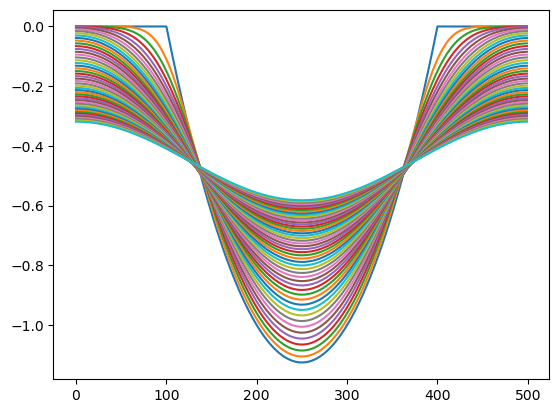

In [111]:
for i in np.arange(0,len(u),2):
    plt.plot(u[i])
plt.show()

#### ------

In [41]:
## THIS ONE IS GOOD!

a = 2 # Diffusivity constant
L = 100 # Length of Domain
N = 1000 # Number of discretization points ?!
dx = L/N
x = np.arange(-L/2, L/2, dx)

kappa = 2*np.pi*np.fft.fftfreq(N, d = dx)  # WHY this kappa?

u0 = np.zeros_like(x) # Create array x length
u0[int((L/2 - L/10)/dx):int((L/2+L/10)/dx)] = 1
u0hat = np.fft.fft(u0)

u0hat_ri = np.concatenate((u0hat.real,u0hat.imag))
u0hat_ri

dt = 0.1
t = np.arange(0,10,dt)

def rhsHeat(uhat_ri,t,kappa,a):
    uhat = uhat_ri[:N] + (1j) * uhat_ri[N:]
    d_uhat = -a**2 * (np.power(kappa,2)) * uhat
    d_uhat_ri = np.concatenate((d_uhat.real,d_uhat.imag))
    return d_uhat_ri

uhat_ri = odeint(rhsHeat, u0hat_ri, t, args = (kappa,a))

uhat = uhat_ri[:,:N] + (1j) * uhat_ri[:,:N]

u = np.zeros_like(uhat)

for k in range(len(t)):
    u[k,:] = np.fft.ifft(uhat[k,:])
    
u = u.real

u

array([[ 7.10542736e-17,  8.52651283e-17, -5.68434189e-17, ...,
        -2.84217094e-17,  4.26325641e-17, -1.42108547e-16],
       [-5.68434189e-17,  8.52651283e-17, -1.13686838e-16, ...,
         1.70530257e-16, -1.13686838e-16,  2.27373675e-16],
       [-4.83169060e-16, -5.25801624e-16, -4.83169060e-16, ...,
        -4.54747351e-16, -3.97903932e-16, -4.83169060e-16],
       ...,
       [ 5.60630367e-06,  5.61408542e-06,  5.63744835e-06, ...,
         5.67644549e-06,  5.63744835e-06,  5.61408542e-06],
       [ 6.25763944e-06,  6.26615236e-06,  6.29171001e-06, ...,
         6.33436915e-06,  6.29171001e-06,  6.26615236e-06],
       [ 6.96946173e-06,  6.97875620e-06,  7.00665978e-06, ...,
         7.05323308e-06,  7.00665978e-06,  6.97875620e-06]])

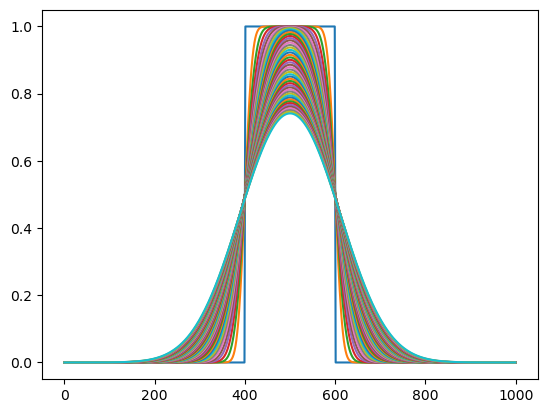

In [43]:
for i in np.arange(0,len(u),2):
    plt.plot(u[i])
plt.show()

# Section V: Functions Testing

In [ ]:
import heat_equations as h_e

In [ ]:
# Must create input boundary functions
def f_u_0_x(x):
    return x*(x-1)*(x-3)

def f_u_t_0(t):
    return 0

def f_u_t_L(t):
    return 0

In [ ]:
D = 5
L = 3
dx = .1
dt = .1
t_max = 3

In [ ]:
Te2 = h_e.heat_1d_explicit(f_u_0_x, D, dx, L, f_u_t_0, f_u_t_L, t_max, dt_mod=1)
h_e.heat_plotter(Te2,t_max,10)

In [ ]:
Ti2 = h_e.heat_1d_implicit(f_u_0_x, D, dx, dt, L, f_u_t_0, f_u_t_L, t_max)
h_e.heat_plotter(Ti2,t_max,10)

In [ ]:
Tcr2 = h_e.crank_nicholson_1d(f_u_0_x, D, dx, dt, L, f_u_t_0, f_u_t_L, t_max)
h_e.heat_plotter(Tcr2, t_max, 10)

### Problem 5.2.8

In [ ]:
def heat_1d_lossy(f_u_0_x, D, dx, L, f_u_t_0, f_u_t_L, t_max, alpha, dt_mod=1):
    '''
    This function takes in an initial temperature distribution, along with boundary conditions,
    and emits the changes to the temperature distribution based on finite difference analysis.
    
    NOTE 1: This function is NOT optimized for numpy use in Python.  It works well for simple problems, but
    needs to be updated to use Numpy arrays for large datasets.
    
    Parameters:    
    f = the function governing the initial heat condition in the rod, must be a def f() [function]
    D = Heat diffusion constant (aka gamma) [float]
    dx = distance between analysis nodes [float]
    L = length of rod [float]
    u_t_0 = Boundary condition at zero [float]
    u_t_L = Boundary Condition at L [float]
    t_max = max time [integer or float]
    dt_mod = (optional) alter this to change then impact of the time interval in caase solutions are unstable
    
    Returns:
    U = array containing the temperature distributions across length L at time step t=0 to t=t_max
    '''
    
    # First set the time step such that dt </= dx**2/(2*D); this determines mu:
    dt = dx**2 / (2*D) # dt = .001, should be equal to or less than dx^2/(2*D) for stability requirements
    mu = D * (dt/dx**2) * dt_mod # Related to dt above, must be </= to .5
    
    # Generate x nodes across rod:
    Nx = int(L/dx)
    
    # Initialize Array:
    U = []

    # Create holder for first row of array = the initial temperature distribution:
    u_t_x_0 = []

    # Populate holder with initial distribution, need N+1 to include x = 3
    for i in range(Nx+1):
        # Normalize the step
        n = i*dx
        
        # Solve the initial value equation for each node:
        # This try/except statement is put in in case the initial condition is a constant:
        try:
            f_n = f_u_0_x(n)
        except:
            f_n = f_u_0_x
            
        u_t_x_0.append(f_n)
    
    # Replace initial distribution boundary conditions with, well, boundary conditions
    try:
        u_t_x_0[0] = f_u_t_0(t)
    except:
        u_t_x_0[0] = f_u_t_0
            
    try:
        u_t_x_0[-1] = f_u_t_L(t)
    except:
        u_t_x_0[-1] = f_u_t_L
    
    # Add this first row to the Array to return
    U.append(u_t_x_0)

    # Run this loop the number of time steps you want to analyze (note: '_' is a placeholder for loop count)
    for t in range(t_max):

        # First, create empty time step - basically initize an empty list to fill with u(t,x) :
        u_t_x = []
        
        # Now grab the previous time step distribution (the value of u at each x for the previous t):
        u_line = U[-1]

        # Now loop through all 'inner' values, that is 0 < x < L, requiring a range of 1 to N:
        for i in range(1,Nx):
            # Using a modified equation 5.14 to calculate u at each x value:
            u = u_line[i] + mu*(u_line[i+1] + u_line[i-1] - 2*u_line[i]) - (dt * alpha * u_line[i])
            # Append this value to the time step line:
            u_t_x.append(u)

        # Append the first and last values with the boundary conditions.  Use try and except in case constant
        try:
            a = f_u_t_0(t)
        except:
            a = f_u_t_0
            
        try:
            b = f_u_t_L(t)
        except:
            b = f_u_t_L
        
        u_t_x.insert(0,a)
        u_t_x.insert(len(u_line),b)

        # Now append the full solutions matrix with time step distribution:
        U.append(u_t_x) 

    return U

In [ ]:
# Givens:
D = 5 # diffusion constant (gamma above)
dx = .01 # Discrete x step
L = 1 # Length of 'rod'

def f(x):
    return x * (x - 1) * (x - 3)

Tl = heat_1d_lossy(f, D, dx, L, 0, 0, 100, 3, 1)

In [ ]:
Tl

In [ ]:
heat_plotter(Tl,5)